<a href="https://colab.research.google.com/github/GiacomoDiFa/Progetto-MN/blob/main/Copia_di_FinalProject_2022_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
import numpy.linalg
import scipy.linalg

Compile the following notebook and share a link with me sending and e-mail to giovanni.stabile@uniurb.it at least one week before the oral examination. All the implemented function will have to be properly documented and commented.

Compile The following Cell with your information. In case it is a group project, put the info for all the group members

Name1: Giacomo \
Surname1: Di Fabrizio\
Email1: 

Name2: Matteo Marco\
Surname2: Montanari\
Email2: 

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.

In [2]:
def finDif(omega,f,n,bc):
  m = n + 4 #numero di colonne matrice
  h = 1./(m-1)
  x = np.linspace(0,1,m)
  terminenoto = -f(x)
  #print(terminenoto)
  #print("")
  matrix = np.zeros((n, m))  # Inizializza una matrice di zeri
  # Assegna valori alla diagonale principale
  a = -1
  b = +16
  c = -30
  main_diagonal = np.full(min(n, m), a)
  np.fill_diagonal(matrix, main_diagonal)
  # Assegna valori alle altre diagonali sopra e sotto la diagonale principale
  np.fill_diagonal(matrix[:, 1:], b)
  np.fill_diagonal(matrix[:, 2:], c)
  np.fill_diagonal(matrix[:, 3:], b)
  np.fill_diagonal(matrix[:, 4:], a)
  matrix /= 12*(h**2)
  #print(matrix)
  #print("")
  
  d = 2
  e = -1
  r = 2
  
  matrix1 = np.zeros((r,m))
  main_diagonal1 = np.full(min(r,m),d)
  np.fill_diagonal(matrix1,main_diagonal1)
  np.fill_diagonal(matrix1[:,1:],e)
  np.fill_diagonal(matrix1[-1:,:],e)
  matrix1 /= h**2
  #print(matrix1)
  #print("")

  
  matrix2 = np.zeros((r,m))
  np.fill_diagonal(matrix2[:,-1:],e)
  np.fill_diagonal(matrix2[:,-2:],d)
  np.fill_diagonal(matrix2[:,-3:],e)
  matrix2 /= h**2
  #print(matrix2)
  #print("")


 
  A = np.pad(matrix1, ((0, m-matrix1.shape[0]), (0, m-matrix1.shape[1])), mode='constant')
  B = np.pad(matrix2, ((m-matrix2.shape[0], 0), (0, m-matrix2.shape[1])), mode='constant')
  pad_rows = (m - matrix.shape[0]) // 2
  pad_cols = (m - matrix.shape[1]) // 2
  C = np.pad(matrix, (((pad_rows, m - matrix.shape[0] - pad_rows), (pad_cols, m - matrix.shape[1] - pad_cols))), mode='constant')
  D = A+B+C
  #print(A)
  #print("")
  #print(B)
  #print("")
  #print(C)
  #print("")
  #print(D)
  #print("")
  D[0,0] = 1
  D[-1,-1] = 1
  D[0,1] = 0
  D[-1,-2] = 0
  #print("")
  #print(D)
  #print("")
  terminenoto[0] = bc[0]
  terminenoto[-1] = bc[1]
  #print(terminenoto)
  #print("")
  return D,terminenoto

#unica cosa che non mi viene in mente adesso è che se io voglio 7 iterazioni (n) mi viene fuori matrice 11x11. 
#non dovrebbe essere 7x7?
#l'ho fatta venire 11 per 11 per come viene passato il parametro nella funzione, ma non so se come significato "fisico"
#abbia senso che io metto n=7 e torni una matrice 11x11
#la matrice finale è D
#no non torna anche perchè il termine noto b viene di 7 elementi giustamente
#potrei farlo tornare passandogli m nel linspace però non credo abbia senso a livello "fisico" (e l'ho fatto tornare)
#ricordarsi di scommentare le divisioni una volta finito il codice (sono già scommentate)

Call the function using:

In [3]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)

Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

In [4]:
def LU(A):
    A = A.copy()
    N=len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")
            
        A[k+1:N,k] /= A[k,k]
        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]
    
    L=np.tril(A)
    for i in range(N):
        L[i,i]=1.0
    U = np.triu(A)
    return L, U

In [5]:
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]
        
        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]
        
    A[-1,-1] = np.sqrt(A[-1,-1])
    L=np.tril(A)
    return L, L.transpose()

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [6]:
def L_solve(L,rhs):
  x = np.zeros_like(rhs)
  N = len(L)
        
  x[0] = rhs[0]/L[0,0]
  for i in range(1,N):
    x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]
  return x

In [7]:
def U_solve(U,rhs):
  x = np.zeros_like(rhs)
  N=len(U)
              
  x[-1] = rhs[-1]/U[-1,-1]
  for i in reversed(range(N-1)):
    x[i] = (rhs[i] -np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]
  return x

Solve the derived linear system using the implemented functions and plot the computed solution:

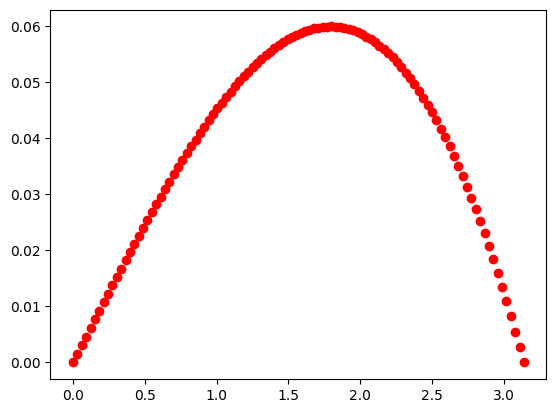

In [8]:
omega = [0,np.pi]
f = lambda x : np.sin(x)
n=100
bc = [0,0]
A, b = finDif(omega, f, n, bc)
x =np.linspace(0,np.pi,n+4)
L, U = LU(A)
w = L_solve(L,b)
u = U_solve(U,w)

_ = plot(x,u,'ro')

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

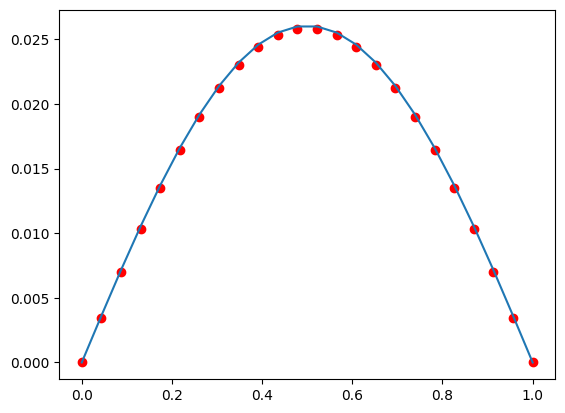

In [9]:
omega_new = [0,1]
n_new=20
x_new = np.linspace(0,1,n_new+4)
f_new = lambda x_new : x_new*(1-x_new)
bc_new = [0,0]
A_new, b_new = finDif(omega_new, f_new, n_new, bc_new)
A1_new = A_new.copy()
u_new = np.linalg.solve(A1_new, b_new) #qua non torna per la dimensione del termine noto come dicevo nello script sopra

u_ex = (x_new**4)/12. - (x_new**3)/6. + x_new/12.

# Plot the FD and exact solution
_ = plot(x_new,u_new,'ro')
_ = plot(x_new,u_ex)


#qua oltre al plot mi sembra di capire che bisogna fare una tabella in cui mostrare come diminuisce l'errore all'aumentare dei punti

Exploit the derived LU factorizations to compute the determinant of the system's matrix $A$ using the original problem formulation.

In [10]:
def condNumb(A):
    pass #TODO
    return condNu

Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

104 30.385470136231934
1.0360635804170863


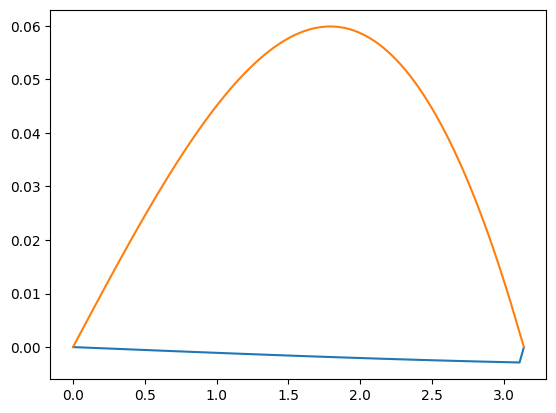

In [21]:
def conjugate_gradient(A, b, P, nmax=len(A), eps=1e-10):
  N=len(A)
  x = np.zeros_like(b)
  tol = eps + 1
  it = 0
  r = b - np.dot(A,x)
  rho_old = 1.
  p_old = np.zeros_like(b)
  while (it < nmax and tol > eps):
    it += 1
    z = np.linalg.solve(P,r)
    rho = np.dot(r,z)
    if (it > 1):
      beta = rho/rho_old
      p = z + beta*p_old
    else:
      p = z
      q = np.dot(A,p)
      alpha = rho/(np.dot(p,q))
      x += p*alpha
      r -= q*alpha
      p_old = p
      rho_old = rho
      tol = np.linalg.norm(r,2)
      
  print(it, tol)
  return x

sol_conjugate_gradient = conjugate_gradient(A, b, np.identity(len(A)))
print(np.linalg.norm(sol_conjugate_gradient - u)/np.linalg.norm(u))
#non so se torna, ho copiato i codici paro paro
#forse non torna perchè la matrice fa cagare?
x_newnew = np.linspace(0,np.pi,n+4)
plot(x_newnew,sol_conjugate_gradient)
plot(x_newnew,u)

Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$, 
$x=\pi$


In [ ]:
#TODO

Given the original $Au = b$ system, implement an algorithm to compute the largest and smallest eigenvalues and the associated eigenvectors of the matrix $A$.

In [16]:
z0 = np.ones_like(x)
def PM(A,z0,tol=1e-5,nmax=500):
    q = z0/np.linalg.norm(z0,2)
    it = 0
    err = tol + 1.
    while it < nmax and err > tol:
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        q = z/np.linalg.norm(z,2)
        
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda_max =", l)
    return l,q

l,x = PM(A,z0)
    
l_np, x_np = np.linalg.eig(A)

print("numpy")
print(l_np)

def IPM(A,x0,mu,tol=1e-5,nmax=500):
    M = A -mu*np.eye(len(A))
    P,L,U = scipy.linalg.lu(M)
    err = tol + 1.
    it = 0
    q = x0/numpy.linalg.norm(x0,2)
    while it < nmax and err > tol :
        y = scipy.linalg.solve(L,np.dot(P.T,q))
        x = scipy.linalg.solve(U,y)
        q = x/numpy.linalg.norm(x,2)
        z = np.dot(A,q)
        l = np.dot(q.T,z)
        err = np.linalg.norm(z-l*q,2)
        it += 1
    print("error =", err, "iterations =", it)
    print("lambda =", l)
    return l,q

l,x = IPM(A,z0,6.)

#ho copiato il codice pari pari, non so se torna in quanto l'errore è abbastanza grande però torna perchè 
#esce dopo numero massimo di iterazioni, se le incremento l'errore diminuisce

error = 61.99716996600794 iterations = 500
lambda_max = -56492.5156962966
numpy
[ 1.74616683e+04  1.74616683e+04 -5.65641821e+04 -5.65127549e+04
 -5.64271312e+04 -5.63074431e+04 -5.61538752e+04 -5.59666639e+04
 -5.57460972e+04 -5.54925137e+04 -5.52063020e+04 -5.48878996e+04
 -5.45377919e+04 -5.41565113e+04 -5.37446354e+04 -5.28316284e+04
 -5.33027862e+04 -5.23318679e+04 -5.18042499e+04 -5.12495576e+04
 -5.06686101e+04 -5.00622607e+04 -4.94313946e+04 -4.87769276e+04
 -4.80998033e+04 -4.66814855e+04 -4.74009914e+04 -4.59423007e+04
 -4.51844719e+04 -4.44090510e+04 -4.36171051e+04 -4.28097139e+04
 -4.19879678e+04 -4.11529655e+04 -4.03058117e+04 -3.94476149e+04
 -3.85794855e+04 -3.77025333e+04 -3.68178657e+04 -3.59265854e+04
 -3.50297885e+04 -3.41285627e+04 -3.32239851e+04 -3.23171207e+04
 -3.14090203e+04 -3.05007194e+04 -2.95932358e+04 -2.86875690e+04
 -2.77846981e+04 -2.68855808e+04 -2.59911520e+04 -2.51023228e+04
 -2.42199796e+04 -2.33449826e+04 -2.24781658e+04 -2.16203356e+04
 -2.077227

Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
#TODO

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

In [ ]:
#TODO